#**Random Forest**
---
##Author: Emmanuel Paalam
##V1: Cleaned only
##Target variable: F3EVERDO

## Import data

In [1]:
import pandas as pd
from google.colab import drive

drive.mount("/content/drive")
## Insert pathway to dataset below
df = pd.read_csv("/content/drive/My Drive/research/SURP 2024/colab/data/cleaned/epaalam-cleaned_els_02_12_byf3pststu_v1_0.csv")

df.dropna(inplace=True)

Mounted at /content/drive


In [2]:
df.shape

(2484, 212)

## Split data

In [3]:
y = df['F3EVERDO']
y.shape

(2484,)

In [4]:
X = df.drop(columns='F3EVERDO', axis=1)
X.shape

(2484, 211)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58, stratify=y)
print(f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

(1987, 211), (497, 211), (1987,), (497,)


##Model development

###Define parameters, scoring

In [6]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [10, 30, 90]
    }

In [7]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)

In [8]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'specificity': make_scorer(specificity_score),
    'npv': make_scorer(npv_score)
}

###Cross-validate

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

grid_search = GridSearchCV(RandomForestClassifier(random_state=2030), param_grid=param_grid, scoring=scoring, refit='f1', cv=StratifiedKFold(n_splits=5), n_jobs=-1, return_train_score=True)

In [10]:
grid_search.fit(X_train, y_train)

# Access and print the cv_results_
results = grid_search.cv_results_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [11]:
# Print the relevant metrics
print("Mean Test Accuracy:", results['mean_test_accuracy'])
print("Mean Test Precision:", results['mean_test_precision'])
print("Mean Test Recall:", results['mean_test_recall'])
print("Mean Test F1:", results['mean_test_f1'])
print("Mean Test Specificity:", results['mean_test_specificity'])
print("Mean Test NPV:", results['mean_test_npv'])

Mean Test Accuracy: [0.94866651 0.94816273 0.93759477 0.94715391 0.94665266 0.93255952
 0.94715391 0.94665266 0.93255952]
Mean Test Precision: [0.92912187 0.95381533 0.96846245 0.92856333 0.96472331 0.86608865
 0.92856333 0.96472331 0.86608865]
Mean Test Recall: [0.66351148 0.65382507 0.57563218 0.64999012 0.64030371 0.54126437
 0.64999012 0.64030371 0.54126437]
Mean Test F1: [0.72402471 0.71373546 0.61170307 0.7065108  0.6956618  0.55483578
 0.7065108  0.6956618  0.55483578]
Mean Test Specificity: [nan nan nan nan nan nan nan nan nan]
Mean Test NPV: [nan nan nan nan nan nan nan nan nan]


In [12]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

Best parameters found:  {'criterion': 'gini', 'min_samples_split': 10}
Best cross-validation score: 0.72


### Observe metrics

Accuracy: 0.9577464788732394
Precision: 1.0
Recall: 0.4166666666666667
F1 Score: 0.5882352941176471
ROC-AUC: 0.9714991564232344
Specificity: 1.0
Test Negative Predictive Value (NPV): 0.9564315352697096
Confusion Matrix:
[[461   0]
 [ 21  15]]


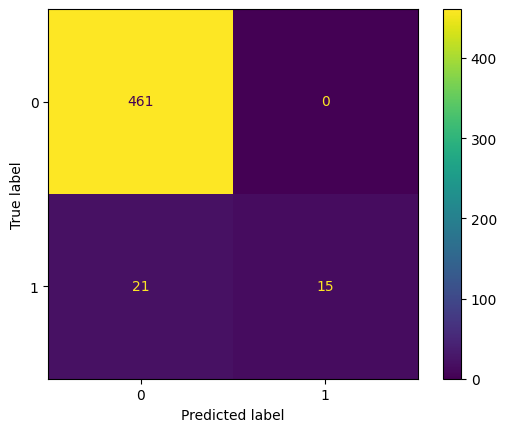

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Calculate test negative predictive value (NPV)
test_npv = tn / (tn + fn)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Specificity: {specificity}")
print(f'Test Negative Predictive Value (NPV): {test_npv}')
print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot()

##Tree visual

In [14]:
import numpy as np

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

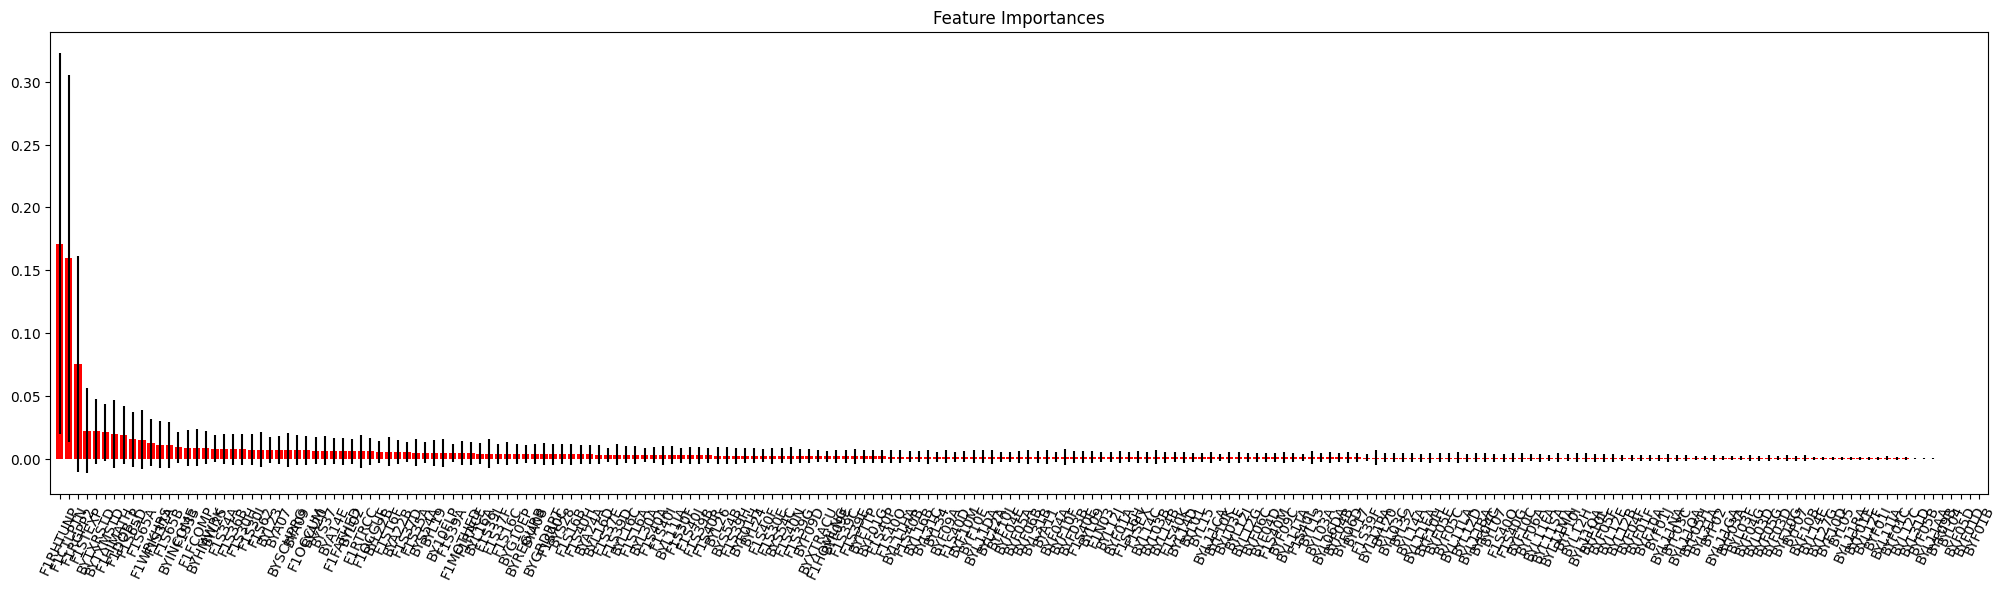

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=65)
plt.xlim([-1, X.shape[1]])
plt.show()

In [16]:
top_features = [X.columns[i] for i in indices[:15]]
print(f"15th most important features: {top_features}")

15th most important features: ['F1RHTUNP', 'F1CTLPTN', 'F1RGPP2', 'F1STEXP', 'BYTXRSTD', 'BYTXMSTD', 'F1HIMATH', 'F1DOB_P', 'F1S65D', 'F1S65A', 'F1WRKHRS', 'F1S37A', 'F1S65B', 'BYINCOME', 'F1S33']
